None을 사용해서 최적화 

1. Lookback window 사이즈를 다르게 주자

2. 리벨런싱 주기를 다르게

3. max_ratio를 다르게

In [1]:
import numpy as np 
import pandas as pd 
import ray
from tqdm import tqdm

from optimize_multi.object_function import * 
from optimize_multi.optimizer_v2 import run_optimizer
from ryu_tool.mytool import * 

2023-05-09 20:50:55,291	INFO worker.py:1625 -- Started a local Ray instance.


In [2]:
price = pd.read_pickle("Data/allstock_adj.pickle")
spx_mask = pd.read_pickle("Data/spx_mask.pickle")

rtn = price.pct_change(fill_method=None)

In [28]:
spx = pd.read_csv("Data/spx_hist.csv", 
                  index_col=0,
                  parse_dates=True).pct_change(fill_method=None)

In [3]:
rtn_ray = ray.put(rtn)
mask_ray = ray.put(spx_mask)

In [4]:
look_back_list = [100, 110, 120, 130, 140, 150, 160, 170]

In [5]:
futures = [run_optimizer.remote(obj_function =obj_sharpe, 
                                rtn_df=rtn_ray,
                                spx_mask=mask_ray,
                                start_year="2006",
                                end_year="2023",
                                rebalancing="Q",
                                look_back_size=lookbacksize,
                                max_ratio=1,
                                shrinkage_method="None") 
           for lookbacksize in look_back_list]
result = ray.get(futures)

100%|██████████| 68/68 [28:53<00:00, 25.50s/it]


(run_optimizer pid=1996) Jobs Done...


100%|██████████| 68/68 [29:23<00:00, 25.93s/it]


(run_optimizer pid=25580) Jobs Done... [repeated 2x across cluster]


100%|██████████| 68/68 [29:23<00:00, 25.93s/it] [repeated 2x across cluster]


(run_optimizer pid=5472) Jobs Done...


 93%|█████████▎| 63/68 [29:37<02:26, 29.33s/it] [repeated 3x across cluster]


(run_optimizer pid=6300) Jobs Done...


100%|██████████| 68/68 [30:35<00:00, 26.99s/it] [repeated 3x across cluster]


(run_optimizer pid=2128) Jobs Done...
(run_optimizer pid=1412) Jobs Done...
(run_optimizer pid=18080) Jobs Done...


100%|██████████| 68/68 [30:41<00:00, 27.08s/it] [repeated 3x across cluster]


In [6]:
ray.shutdown()

In [7]:
result_dict = {}
weight_dict = {}

for i, arg in tqdm(enumerate(look_back_list)):
    rt, weig = simulate_rebalancing(rtn, result[i])
    result_dict[f"Look-Back {str(arg)} Days"] = rt
    weight_dict[str(arg)] = weig

8it [00:15,  1.97s/it]


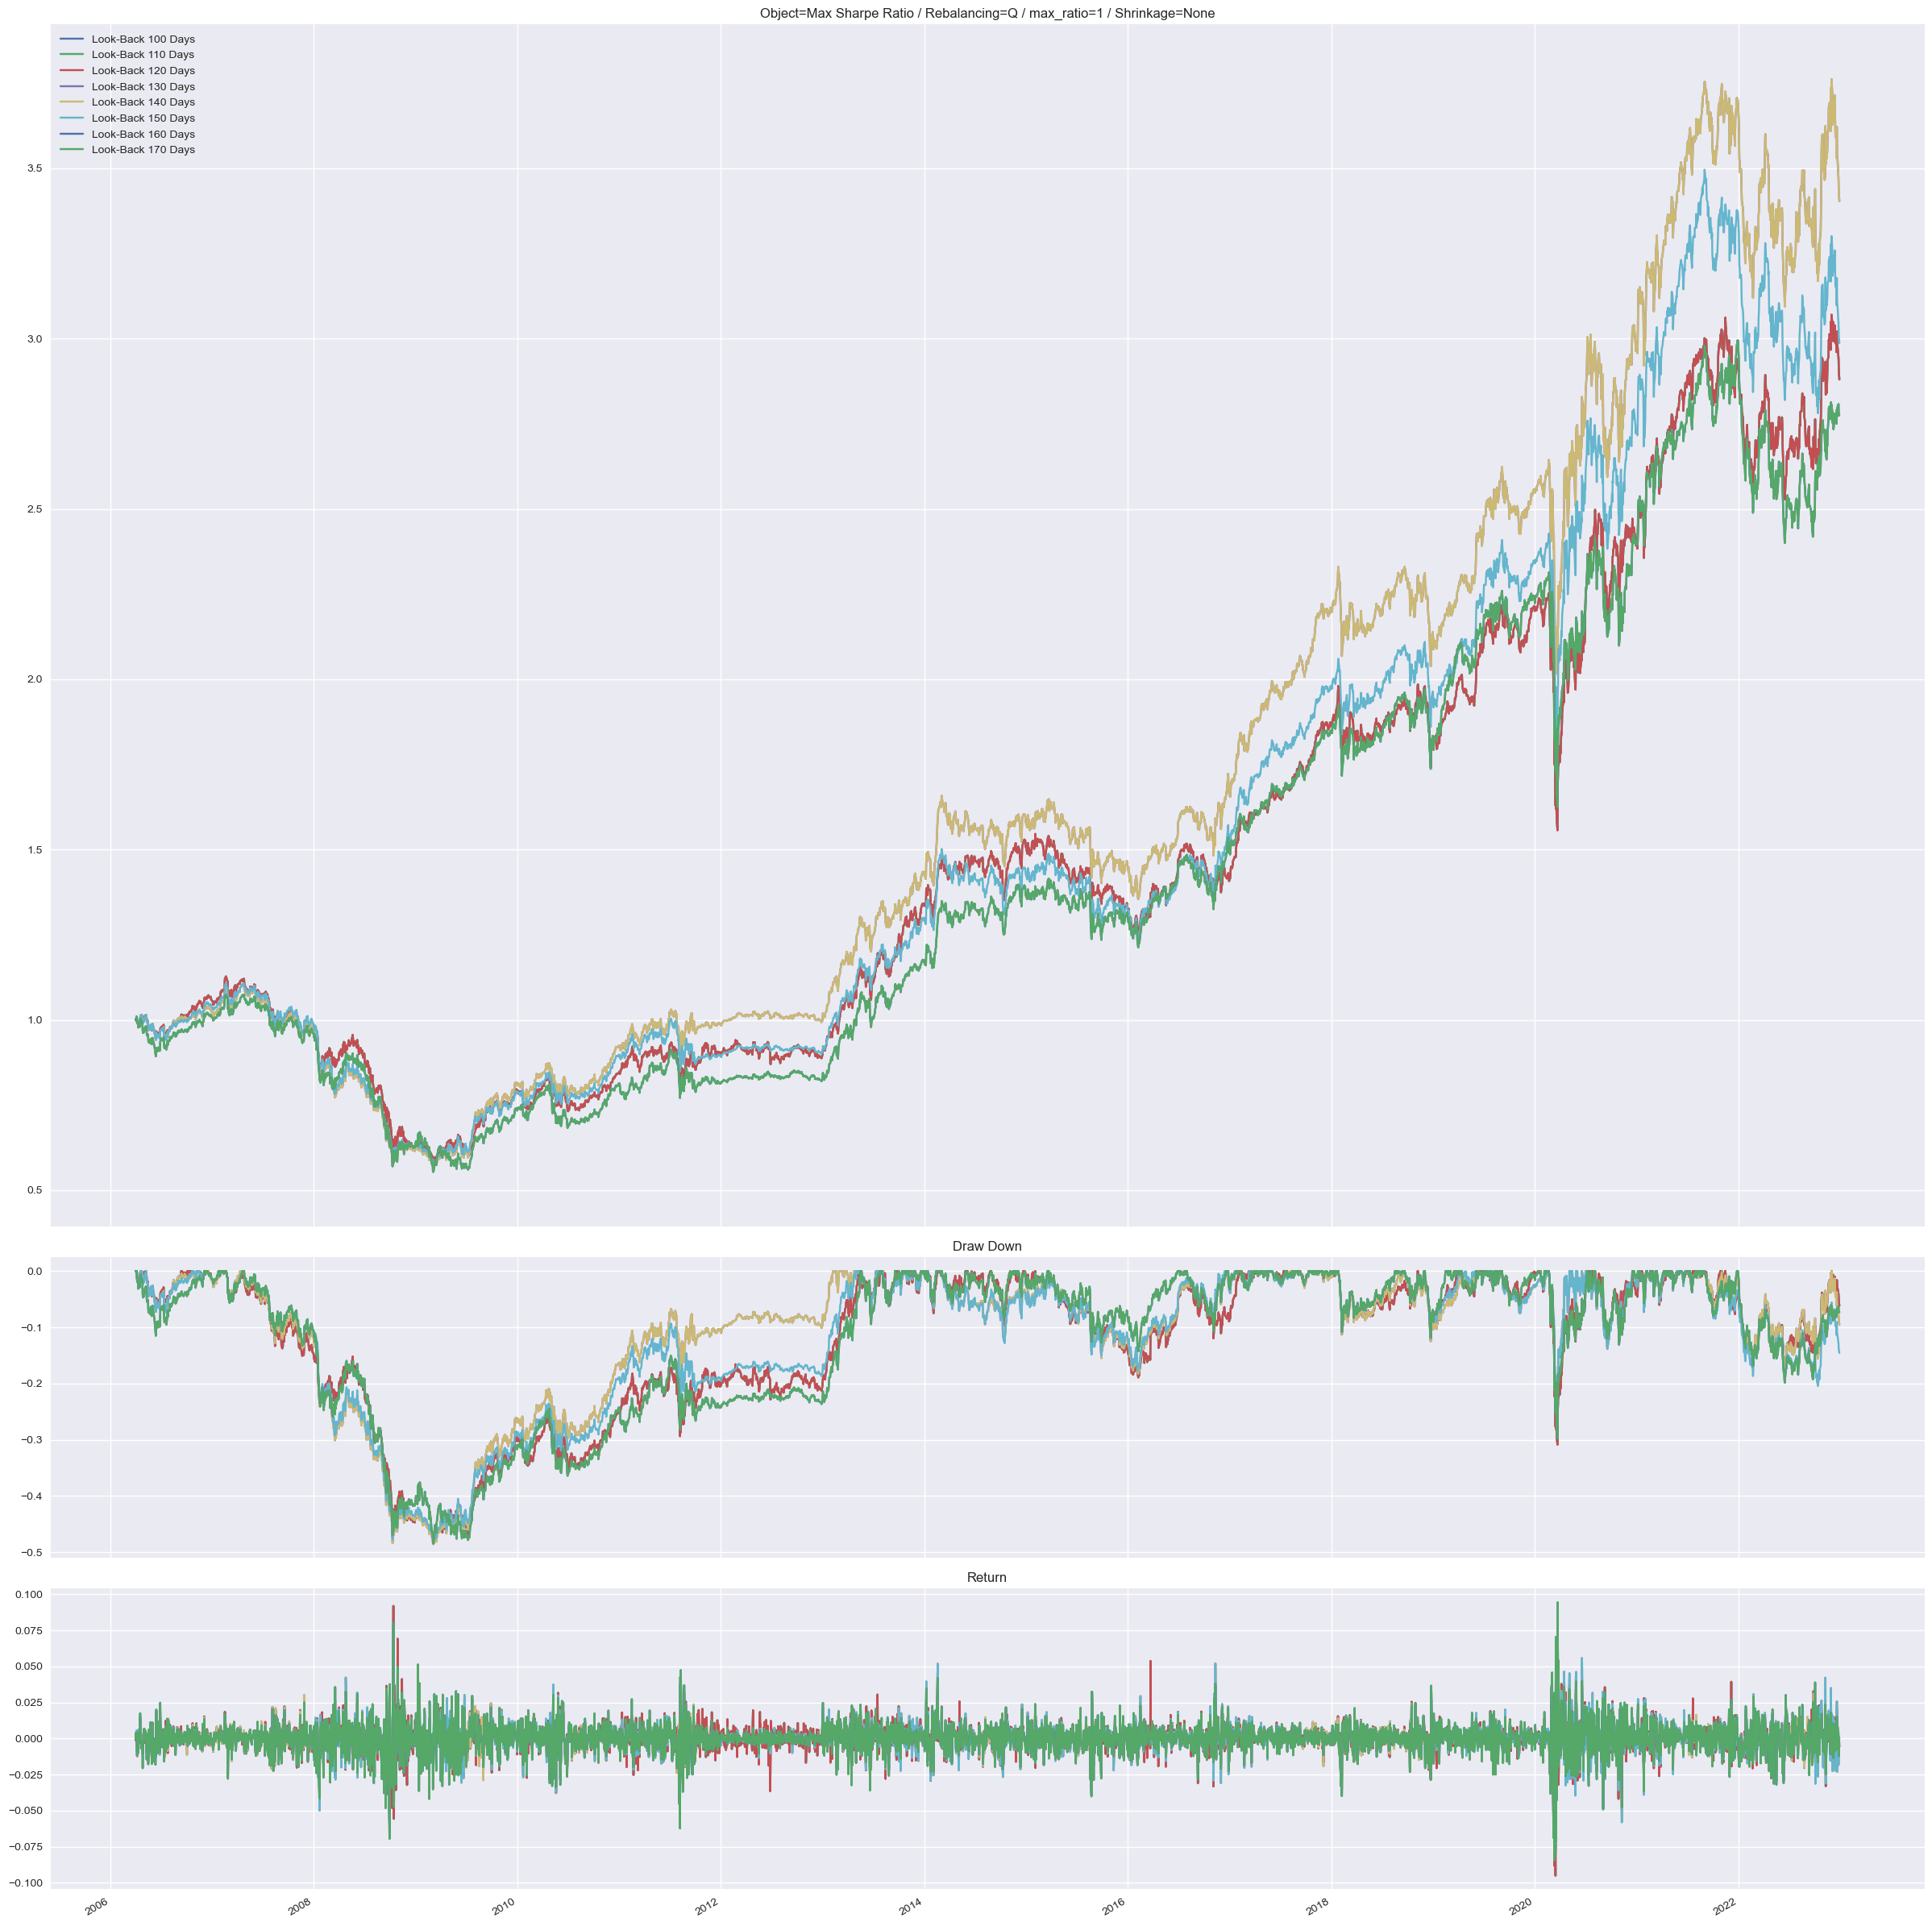

In [8]:
draw_return_result(result_dict,
                   one_plot=True,
                   title="Object=Max Sharpe Ratio / Rebalancing=Q / max_ratio=1 / Shrinkage=None")

In [9]:
stats = print_statistics(result_dict)
stats.columns = [str(day) + "_Days" for day in look_back_list]
stats

,100_Days,110_Days,120_Days,130_Days,140_Days,150_Days,160_Days,170_Days
CAGR,0.064800,0.064800,0.064800,0.075200,0.075200,0.066900,0.062200,0.062200
Mean,0.110720,0.110720,0.110720,0.125120,0.125120,0.113880,0.108580,0.108580
STD,0.195460,0.195460,0.195460,0.195245,0.195245,0.195588,0.200633,0.200633
MDD,0.480000,0.480000,0.480000,0.486000,0.486000,0.480000,0.484000,0.484000
Sharpe,0.566458,0.566458,0.566458,0.640837,0.640837,0.582245,0.541186,0.541186


Text(0.5, 1.0, 'Sharpe / Q / max_ratio=1 / shrinkage=0 / Look Back Window = 130days')

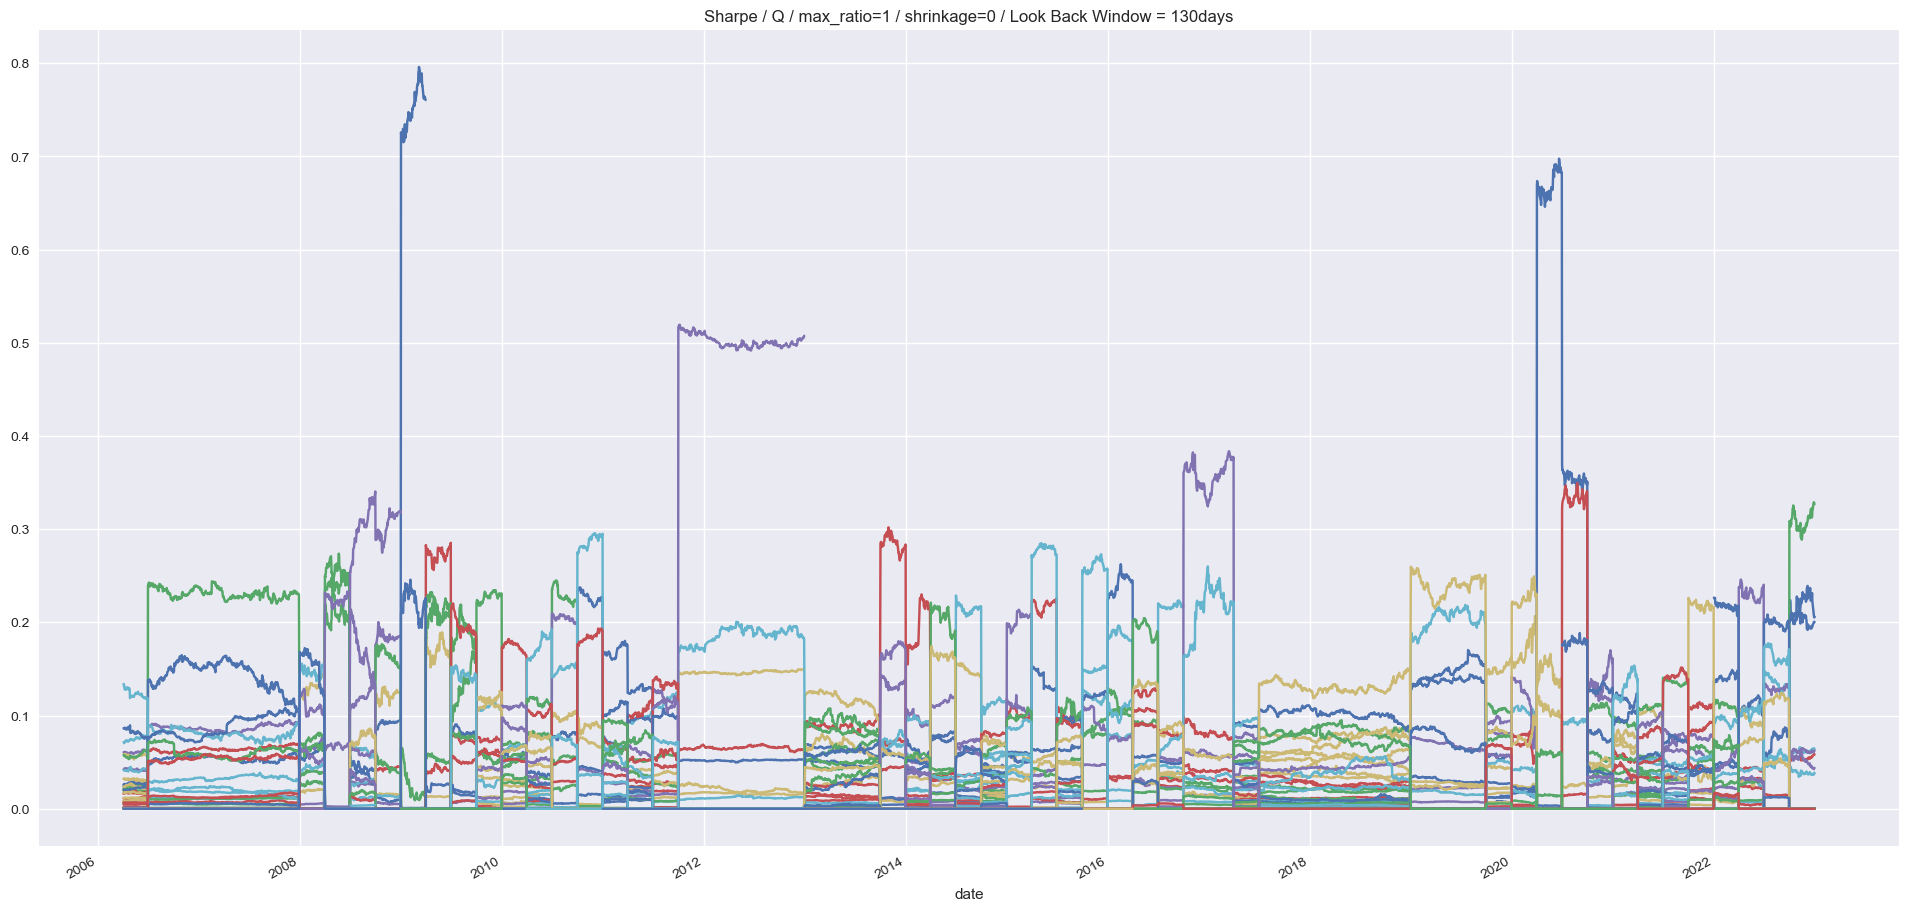

In [13]:
weight_dict["130"].plot(figsize=(24,12),
                        legend=False)
plt.title("Sharpe / Q / max_ratio=1 / shrinkage=0 / Look Back Window = 130days")

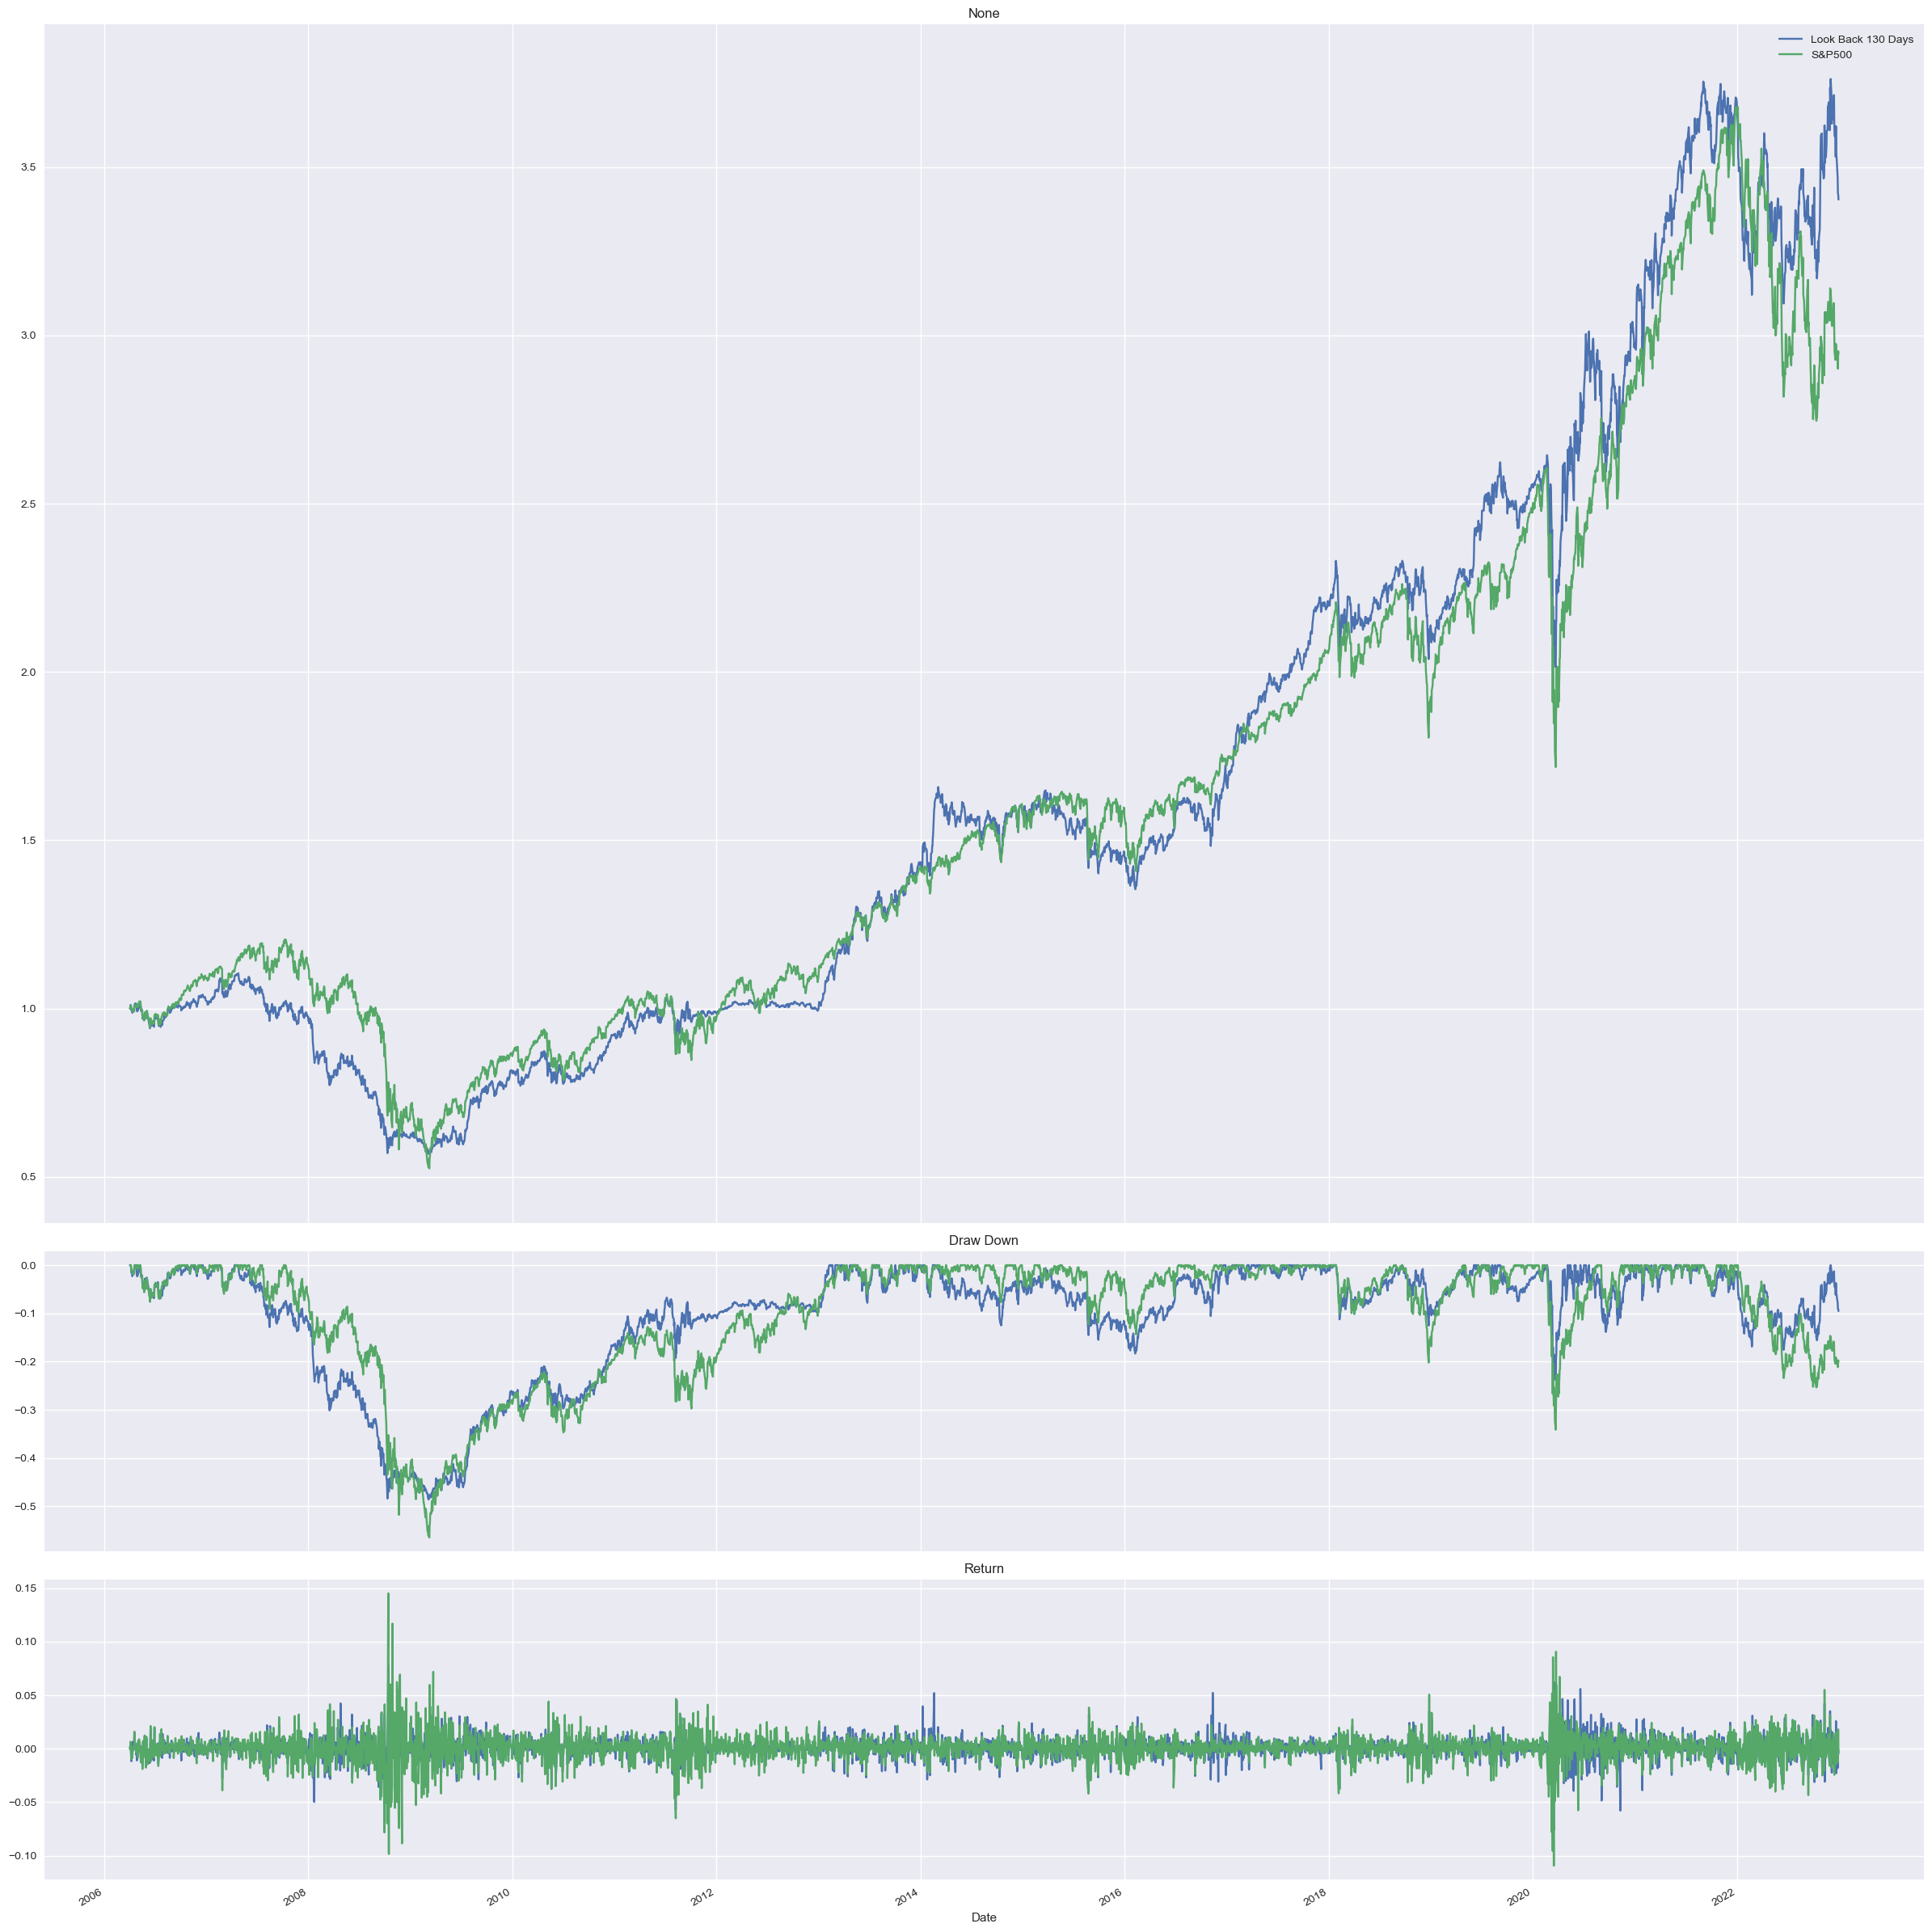

In [42]:
portfolio = result_dict["Look-Back 130 Days"]
spx_sample = spx[portfolio.index[0]:]["Price"] # Series로 변경

draw_return_result({"Look Back 130 Days":portfolio,
                    "S&P500": spx_sample},
                   one_plot=True)

In [45]:
st = print_statistics({"Look Back 130 Days":portfolio,
                       "S&P500": spx_sample})
st.columns = ["130 Days","S&P500"]
st

,130 Days,S&P500
CAGR,0.075200,0.065700
Mean,0.125120,0.122960
STD,0.195245,0.242600
MDD,0.486000,0.565000
Sharpe,0.640837,0.506843
